# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [147]:
# Import warnings
import warnings

warnings.filterwarnings(action="ignore")

In [148]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


In [149]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [152]:
# Try loading one file

df = pd.read_parquet('Datasets and Dictionary\\trip_records\\2023-1.parquet')

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [158]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [159]:
# from google.colab import drive
# drive.mount('/content/drive')

In [160]:
# # Take a small percentage of entries from each hour of every date.
# # Iterating through the monthly data:
# #   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# # Create a single dataframe for the year combining all the monthly data

# # Select the folder having data files
# import os

# # Select the folder having data files
# os.chdir('C:\\Users\\Omkar Ardalkar\\Downloads\\Datasets and Dictionary-NYC\\Starter Notebook - EDA NYC Taxi\\Datasets and Dictionary\\trip_records')

# # Create a list of all the twelve files to read
# file_list = os.listdir()

# # initialise an empty dataframe
# df = pd.DataFrame()


# # iterate through the list of files and sample one by one:
# for file_name in file_list:
#     try:
#         # file path for the current file
#         file_path = os.path.join(os.getcwd(), file_name)

#         # Reading the current file
#         month_data = pd.read_parquet(file_path)
#         month_data['date'] = month_data['tpep_pickup_datetime'].dt.date
#         month_data['hour'] = month_data['tpep_pickup_datetime'].dt.hour

#         # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
#         # After completing iteration through each date, we will append this data to the final dataframe.
#         sampled_data = pd.DataFrame()

#         # Loop through dates and then loop through every hour of each date
#         for date in month_data['date'].unique():
#             day_data=month_data[month_data['date']==date]

#             # Iterate through each hour of the selected date
#             for hour in range(24):
#                 hourly_data=day_data[day_data['hour']==hour]
                
#                 # Sample 5% of the hourly data randomly
#                 sampled_hour = hourly_data.sample(frac=0.02, random_state=42)

#                 # add data of this hour to the dataframe
#                 sampled_data = pd.concat([sampled_data, sampled_hour], ignore_index=True)
#         # Concatenate the sampled data of all the dates to a single dataframe
#         df = pd.concat([df, sampled_data], ignore_index=True)

#     except Exception as e:
#         print(f"Error reading file {file_name}: {e}")

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [162]:
# Store the df in csv/parquet
df.to_parquet('sample_df.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [165]:
# Load the new data file
df = pd.read_parquet('Datasets and Dictionary\\trip_records\\sample_df.parquet')

In [166]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4          19.24         NaN               None            66           107   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2        32.40    6.0      0.5        0.00           0.0   
1             1         7.90    1.0      0.5        2.58           0.0   
2             2        11.40    1.0      0.5        0.00           0.0   
3             2         6.50    1.0      0.5        0.00           0.0   
4             0        25.64    0.0      0.5        5.93           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.15                   0.0         1.25   
1                    1.0         15.48                   2.5         0.00   
2                    1.0         16.40                   2.5         0.00   
3                    1.0         11.50                   2.5         0.00   
4                    1.0         35.57                   NaN          NaN   

         date  hour  Airport_fee  
0  2023-01-01     0          NaN  
1  2023-01-01     0          NaN  
2  2023-01-01     0          NaN  
3  2023-01-01     0          NaN  
4  2023-01-01     0          NaN

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758584 entries, 0 to 758583
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               758584 non-null  int64         
 1   tpep_pickup_datetime   758584 non-null  datetime64[us]
 2   tpep_dropoff_datetime  758584 non-null  datetime64[us]
 3   passenger_count        732914 non-null  float64       
 4   trip_distance          758584 non-null  float64       
 5   RatecodeID             732914 non-null  float64       
 6   store_and_fwd_flag     732914 non-null  object        
 7   PULocationID           758584 non-null  int64         
 8   DOLocationID           758584 non-null  int64         
 9   payment_type           758584 non-null  int64         
 10  fare_amount            758584 non-null  float64       
 11  extra                  758584 non-null  float64       
 12  mta_tax                758584 non-null  floa

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [170]:
# Fix the index and drop any columns that are not needed
df.reset_index(drop=True, inplace=True)
df.index = df.index + 1

df.drop(columns=['store_and_fwd_flag', 'mta_tax'], inplace=True)


**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [172]:
# Combine the two airport fee columns
df.airport_fee.isnull().sum(), df.Airport_fee.isnull().sum()

(699173, 85081)

In [173]:
df['Airport_Fee'] = df['airport_fee'].combine_first(df['Airport_fee'])
df.drop(columns=['airport_fee', 'Airport_fee'], inplace=True)

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [175]:
# check where values of fare amount are negative
df[df['fare_amount'] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, date, hour, Airport_Fee]
Index: []

Did you notice something different in the `RatecodeID` column for above records?

In [177]:
# Analyse RatecodeID for the negative fare amounts
df.loc[df.fare_amount < 0, 'RatecodeID']

Series([], Name: RatecodeID, dtype: float64)

In [178]:
# Find which columns have negative values
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
negative_columns = df[numeric_cols].lt(0).any()
negative_columns[negative_columns]

extra                    True
improvement_surcharge    True
total_amount             True
congestion_surcharge     True
Airport_Fee              True
dtype: bool

In [179]:
# fix these negative values
negative_cols = negative_columns[negative_columns].index.tolist()
df=df[~(df[negative_cols] < 0).any(axis=1)]

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [182]:
# Find the proportion of missing values in each column
missing_proportion_percent=(df.isnull().mean())*100
missing_proportion_percent.sort_values(ascending=False)

Airport_Fee              3.38411
passenger_count          3.38411
RatecodeID               3.38411
congestion_surcharge     3.38411
tip_amount               0.00000
hour                     0.00000
date                     0.00000
total_amount             0.00000
improvement_surcharge    0.00000
tolls_amount             0.00000
VendorID                 0.00000
extra                    0.00000
tpep_pickup_datetime     0.00000
payment_type             0.00000
DOLocationID             0.00000
PULocationID             0.00000
trip_distance            0.00000
tpep_dropoff_datetime    0.00000
fare_amount              0.00000
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [184]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
df[df.isnull().any(axis=1)].head()

df['passenger_count'].fillna(df.passenger_count.mode()[0], inplace=True)

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [187]:
# Fix missing values in 'RatecodeID'
df['RatecodeID'].fillna(df.RatecodeID.mode()[0], inplace=True)

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [189]:
# handle null values in congestion_surcharge
df['congestion_surcharge'].fillna(df.congestion_surcharge.mode()[0], inplace=True)

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [191]:
# Handle any remaining missing values
# df['store_and_fwd_flag'].fillna(df.congestion_surcharge.mode()[0], inplace=True)
df['Airport_Fee'].fillna(df.congestion_surcharge.mode()[0], inplace=True)

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [194]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
df.describe()

VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  758545.000000                      758545                      758545   
mean        1.733697  2023-07-02 20:08:51.075093  2023-07-02 20:26:14.302154   
min         1.000000         2023-01-01 00:02:19         2023-01-01 00:09:40   
25%         1.000000         2023-04-02 16:14:04         2023-04-02 16:33:46   
50%         2.000000         2023-06-27 15:52:17         2023-06-27 16:13:38   
75%         2.000000         2023-10-06 19:40:50         2023-10-06 20:00:08   
max         6.000000         2023-12-31 23:57:51         2024-01-01 20:14:57   
std         0.447479                         NaN                         NaN   

       passenger_count  trip_distance     RatecodeID   PULocationID  \
count    758545.000000   758545.00000  758545.000000  758545.000000   
mean          1.355989        3.70544       1.622726     165.297263   
min           0.000000        0.00000       1.000000       1.000000   
25%           1.000000        1.05000       1.000000     132.000000   
50%           1.000000        1.79000       1.000000     162.000000   
75%           1.000000        3.40000       1.000000     234.000000   
max           9.000000    34804.51000      99.000000     265.000000   
std           0.879519       72.91106       7.330909      63.975327   

        DOLocationID   payment_type    fare_amount          extra  \
count  758545.000000  758545.000000  758545.000000  758545.000000   
mean      164.003142       1.164225      20.017021       1.585008   
min         1.000000       0.000000       0.000000       0.000000   
25%       113.000000       1.000000       9.300000       0.000000   
50%       162.000000       1.000000      13.500000       1.000000   
75%       234.000000       1.000000      21.900000       2.500000   
max       265.000000       4.000000  143163.450000      14.250000   
std        69.815416       0.507384     165.353487       1.825691   

          tip_amount   tolls_amount  improvement_surcharge   total_amount  \
count  758545.000000  758545.000000          758545.000000  758545.000000   
mean        3.541388       0.593697               0.999046      29.068763   
min         0.000000       0.000000               0.000000       0.000000   
25%         1.000000       0.000000               1.000000      15.960000   
50%         2.850000       0.000000               1.000000      21.000000   
75%         4.420000       0.000000               1.000000      30.810000   
max       180.000000     143.000000               1.000000  143167.450000   
std         4.024641       2.183903               0.028491     165.909048   

       congestion_surcharge           hour    Airport_Fee  
count         758545.000000  758545.000000  758545.000000  
mean               2.313931      14.264719       0.222355  
min                0.000000       0.000000       0.000000  
25%                2.500000      11.000000       0.000000  
50%                2.500000      15.000000       0.000000  
75%                2.500000      19.000000       0.000000  
max                2.500000      23.000000       2.500000  
std                0.656164       5.807412       0.624488

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [198]:
# remove passenger_count > 6
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

In [199]:
# Continue with outlier handling
df = df[~((df['trip_distance'] < 0.1) & (df['fare_amount'] > 300))]
df = df[~((df['trip_distance'] == 0) & (df['fare_amount'] == 0) & (df['PULocationID'] != df['DOLocationID']))]
df = df[df['trip_distance'] <= 250]
df = df[df['payment_type'].isin([1, 2, 3, 4, 5, 6])]
df = df[~((df['trip_distance'] == 0) & (df['fare_amount'] > 0))]
df = df[~((df['trip_distance'] < 1) & (df['fare_amount'] > 1000))]
df = df[~((df.tip_amount > df.fare_amount) & (df.total_amount>100))]

In [200]:
# Do any columns need standardising?
# As we are only doing a visual EDA, there is no need to standardize.

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [202]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'date',
 'hour',
 'Airport_Fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: categorical
* `tpep_pickup_datetime`: categorical
* `tpep_dropoff_datetime`: categorical
* `passenger_count`: numerical
* `trip_distance`: numerical
* `RatecodeID`: categorical
* `PULocationID`: categorical
* `DOLocationID`: categorical
* `payment_type`: categorical
* `pickup_hour`: categorical
* `trip_duration`: numerical


The following monetary parameters belong in the same category, is it categorical or numerical? (Numerical)


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

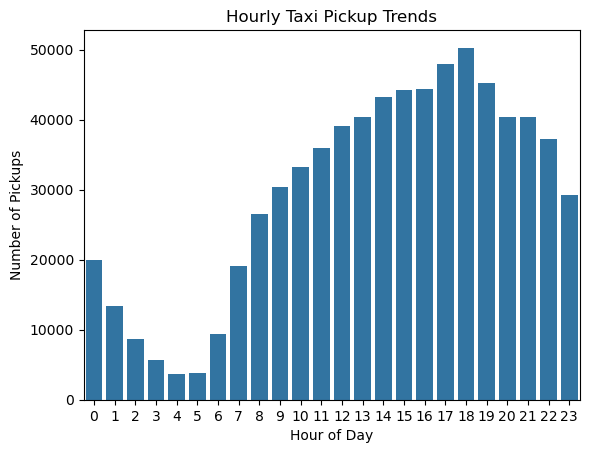

In [207]:
# Find and show the hourly trends in taxi pickups
hourly_pickups=df.groupby('hour').size()
sns.barplot(x=hourly_pickups.index,y=hourly_pickups.values)
plt.title('Hourly Taxi Pickup Trends')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(0, 24))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

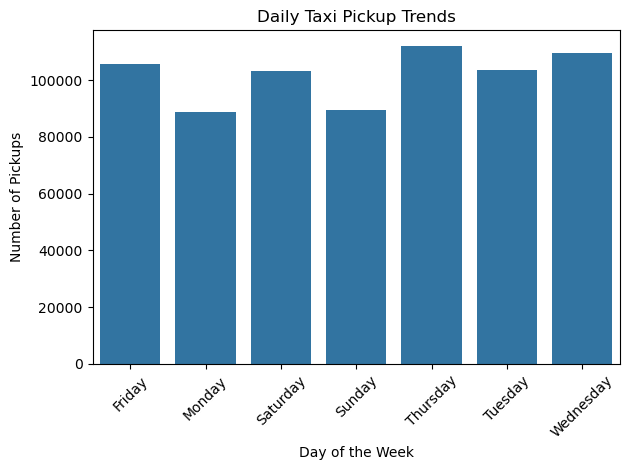

In [208]:
# Find and show the daily trends in taxi pickups (days of the week)
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()
daily_pickups = df.groupby('day_of_week').size()
sns.barplot(daily_pickups)
plt.title('Daily Taxi Pickup Trends')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

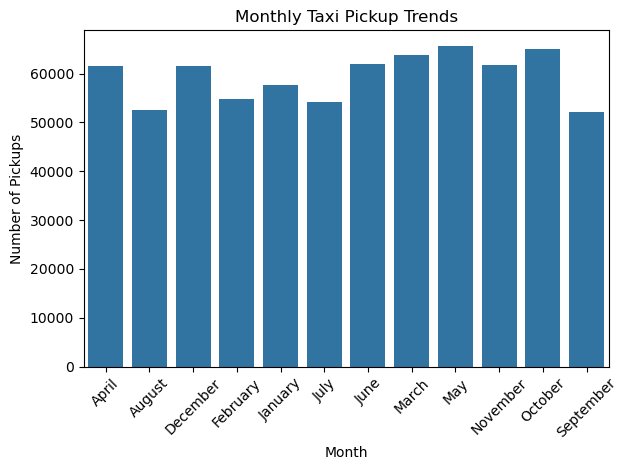

In [209]:
# Show the monthly trends in pickups
df['month'] = df['tpep_pickup_datetime'].dt.month_name()
monthly_pickups = df.groupby('month').size()
sns.barplot(monthly_pickups)
plt.title('Monthly Taxi Pickup Trends')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.grid(True)
plt.show

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [212]:
# List of financial columns
columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

# Check for zero or negative values
for col in columns_to_check:
    zero_count = (df[col] == 0).sum()
    negative_count = (df[col] < 0).sum()
    print(f"{col}: Zero values = {zero_count}, Negative values = {negative_count}")

fare_amount: Zero values = 202, Negative values = 0
tip_amount: Zero values = 155500, Negative values = 0
total_amount: Zero values = 98, Negative values = 0
trip_distance: Zero values = 96, Negative values = 0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [215]:
# Create a df with non zero entries for the selected parameters.
non_zero_df = df[(df[columns_to_check] != 0).all(axis=1)]

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

<function matplotlib.pyplot.show(close=None, block=None)>

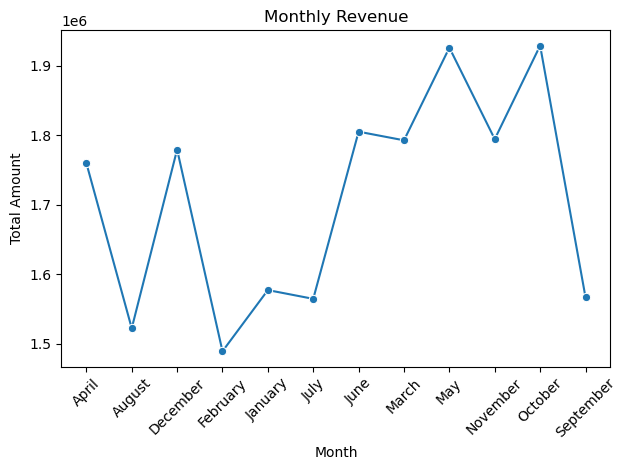

In [217]:
# Group data by month and analyse monthly revenue
monthly_revenue = df.groupby('month')['total_amount'].sum().reset_index()
sns.lineplot(x='month',y='total_amount',data=monthly_revenue,marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [219]:
# Calculate proportion of each quarter
df['quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q').astype(str)
quarterly_revenue = df.groupby('quarter')['total_amount'].sum()
quarterly_proportion = (quarterly_revenue / quarterly_revenue.sum()) * 100
quarterly_proportion

quarter
2023Q1    23.694638
2023Q2    26.777514
2023Q3    22.693479
2023Q4    26.834369
Name: total_amount, dtype: float64

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [221]:
df_filtered = df[df['trip_distance'] > 0]
correlation = df_filtered['trip_distance'].corr(df_filtered['fare_amount'])
print(f"Correlation between trip_distance and fare_amount: {correlation:.3f}")


Correlation between trip_distance and fare_amount: 0.943


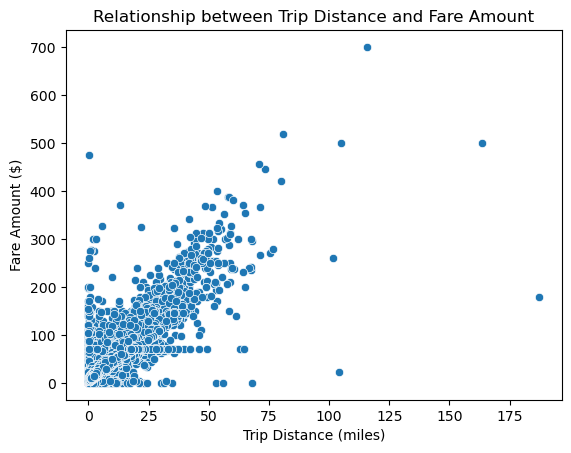

In [222]:
# Show how trip fare is affected by distance
# plt.figure(figsize=(8, 5))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df_filtered)
plt.title('Relationship between Trip Distance and Fare Amount')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.show()


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

Correlation between fare_amount and trip_duration: 0.27


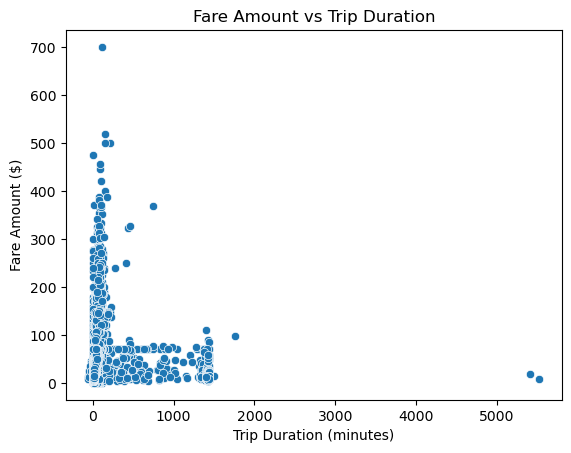

In [224]:
# Show relationship between fare and trip duration
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60  # duration in minutes
cor1 = df['fare_amount'].corr(df['trip_duration'])
print(f"Correlation between fare_amount and trip_duration: {cor1:.2f}")
sns.scatterplot(x='trip_duration', y='fare_amount', data=df)
plt.title('Fare Amount vs Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.show()

Correlation between fare_amount and passenger_count: 0.04


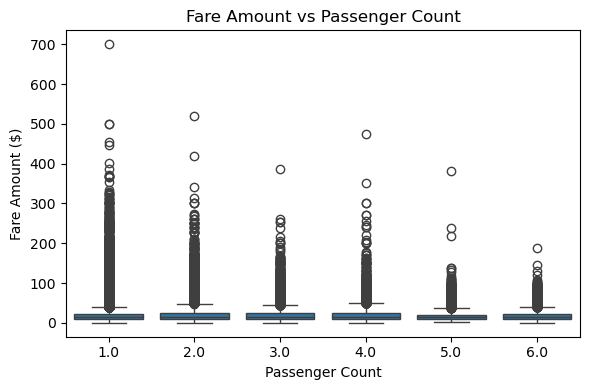

In [225]:
# Show relationship between fare and number of passengers
cor2 = df['fare_amount'].corr(df['passenger_count'])
print(f"Correlation between fare_amount and passenger_count: {cor2:.2f}")
plt.figure(figsize=(6, 4))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Fare Amount vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.tight_layout()
plt.show()

Correlation between tip_amount and trip_distance: 0.59


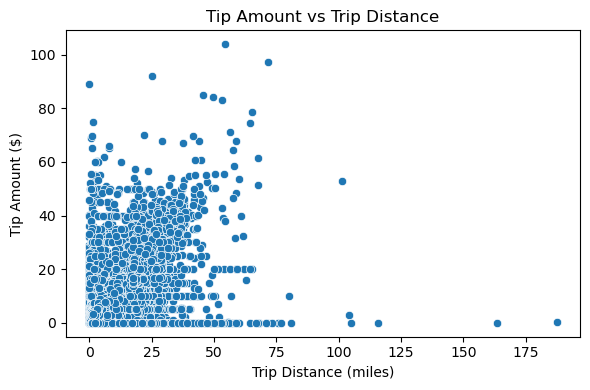

In [226]:
# Show relationship between tip and trip distance
cor3 = df['tip_amount'].corr(df['trip_distance'])
print(f"Correlation between tip_amount and trip_distance: {cor3:.2f}")
plt.figure(figsize=(6, 4))
sns.scatterplot(x='trip_distance', y='tip_amount', data=df)
plt.title('Tip Amount vs Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.tight_layout()
plt.show()


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

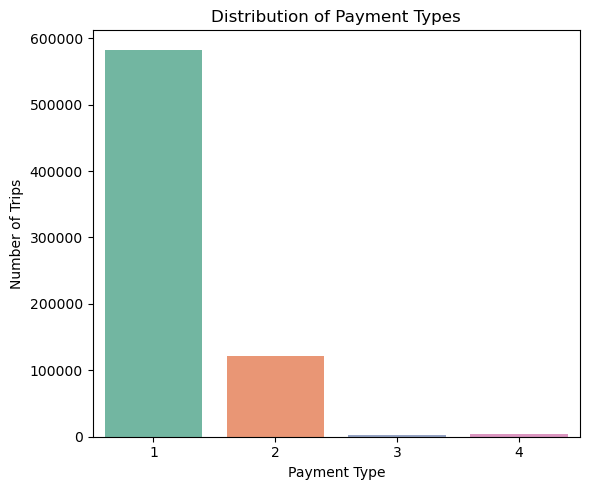

In [228]:
# Analyse the distribution of different payment types (payment_type).
df.payment_type.value_counts()

plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='payment_type', palette="Set2")
plt.title("Distribution of Payment Types")
plt.xlabel("Payment Type")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [233]:
# pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [235]:
import geopandas as gpd


# Read the shapefile using geopandas
zones = gpd.read_file('C:\\Users\\Omkar Ardalkar\\Downloads\\Datasets and Dictionary-NYC\\Starter Notebook - EDA NYC Taxi\\Datasets and Dictionary\\taxi_zones\\taxi_zones.shp')# read the .shp file using gpd
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

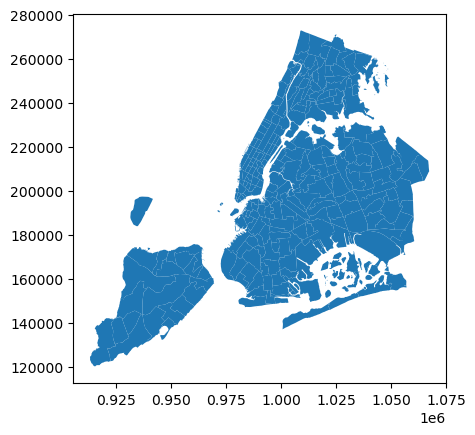

In [237]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [240]:
# Merge zones and trip records using locationID and PULocationID
zones = zones.rename(columns={'LocationID': 'PULocationID'})
df_zones = df.merge(zones, on='PULocationID',how='left')

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [242]:
# Group data by location and calculate the number of trips
df_zones_grouped=df_zones.groupby('PULocationID').size().reset_index(name='num_trips')
df_zones_grouped

PULocationID  num_trips
0               1         20
1               3         12
2               4        698
3               5          4
4               6          9
..            ...        ...
240           261       3756
241           262       9095
242           263      13561
243           264       6181
244           265        134

[245 rows x 2 columns]

**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [244]:
# Merge trip counts back to the zones GeoDataFrame
zones=zones.merge(df_zones_grouped,on='PULocationID',how='left')
zones.num_trips=zones.num_trips.fillna(0)

In [245]:
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  PULocationID  \
0         1    0.116357    0.000782           Newark Airport             1   
1         2    0.433470    0.004866              Jamaica Bay             2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens             3   
3         4    0.043567    0.000112            Alphabet City             4   
4         5    0.092146    0.000498            Arden Heights             5   

         borough                                           geometry  num_trips  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...       20.0  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...        0.0  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...       12.0  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...      698.0  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...        4.0

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

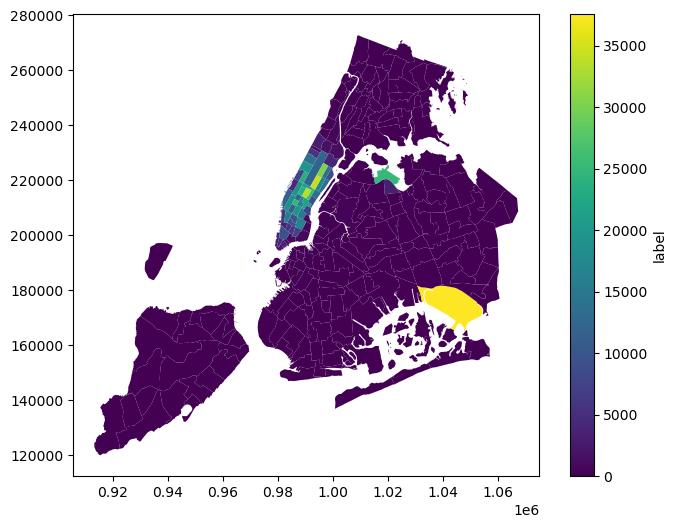

In [249]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (8,6))

# Plot the map and display it
zones.plot(
    column = 'num_trips',
    ax = ax,
    legend = True,
    legend_kwds = {'label': "label", 'orientation': "vertical"})
plt.show()


In [250]:
# can you try displaying the zones DF sorted by the number of trips?
zones_sorted=zones.sort_values(by='num_trips',ascending=False)

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

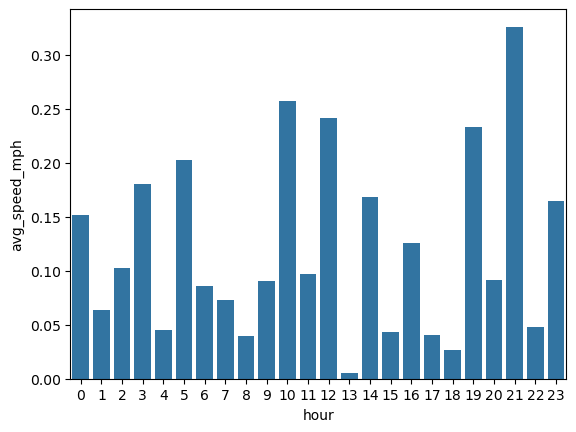

In [309]:
# Find routes which have the slowest speeds at different times of the day
df_speed = df_zones[(df_zones['tpep_dropoff_datetime'] > df_zones['tpep_pickup_datetime']) & df_zones.trip_distance>0]
df_speed['route'] = df_speed['PULocationID'].astype(str) + '-' + df_speed['DOLocationID'].astype(str)
speed_by_route_hour = (
    df_speed.groupby(['route', 'hour'])
    .agg({'trip_distance': 'mean', 'trip_duration': 'mean'})
    .reset_index()
)
speed_by_route_hour['avg_speed_mph'] = speed_by_route_hour['trip_distance'] / (speed_by_route_hour['trip_duration']/60)
slowest_routes = speed_by_route_hour.sort_values(['hour', 'avg_speed_mph']).groupby('hour').first().reset_index()
sns.barplot(data=slowest_routes,x='hour',y='avg_speed_mph')
plt.show()

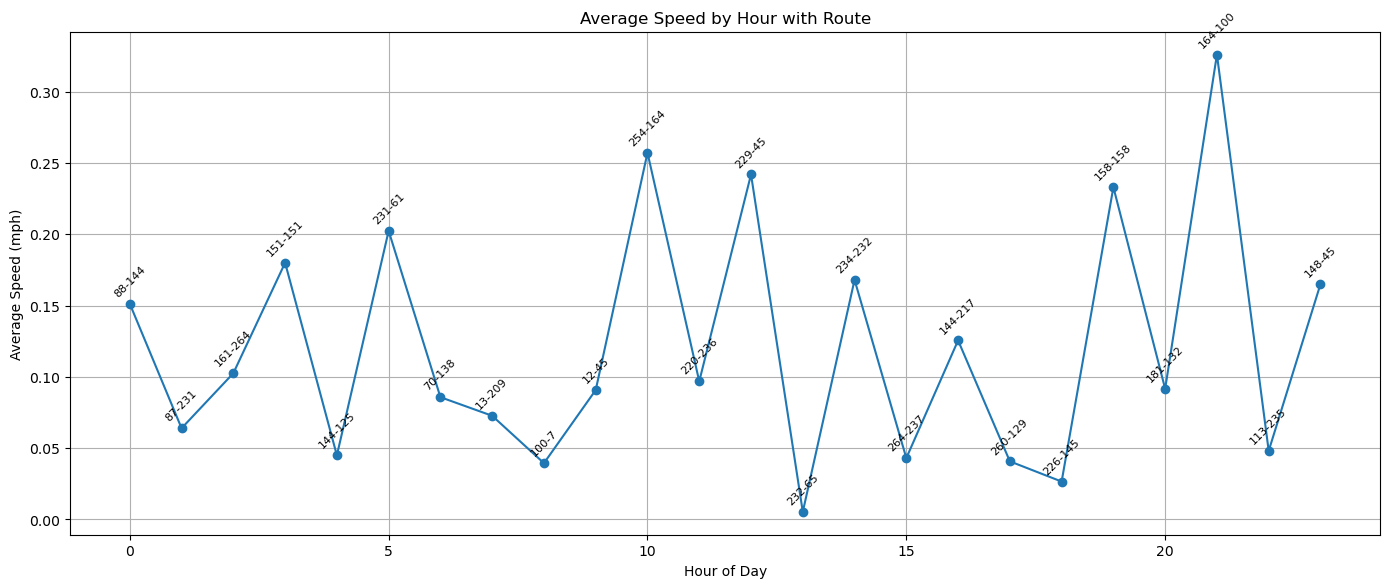

In [318]:
plt.figure(figsize=(14, 6))
plt.plot(slowest_routes['hour'], slowest_routes['avg_speed_mph'], marker='o', linestyle='-')

# Annotate each point with the corresponding route
for i, row in slowest_routes.iterrows():
    plt.text(row['hour'], row['avg_speed_mph'] + 0.005, row['route'], fontsize=8, ha='center', rotation=45)

plt.xlabel('Hour of Day')
plt.ylabel('Average Speed (mph)')
plt.title('Average Speed by Hour with Route')
plt.grid(True)
plt.tight_layout()
plt.show()

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

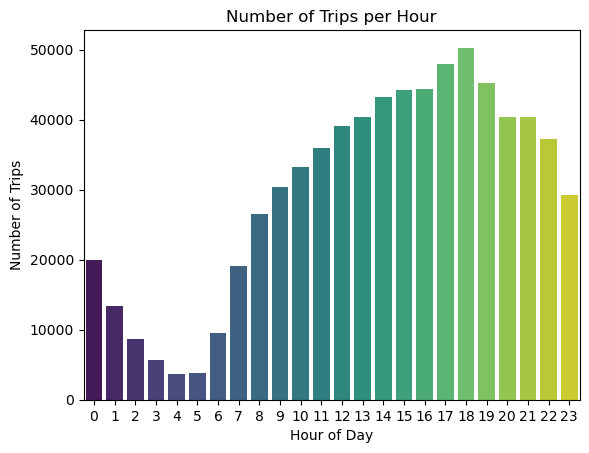

In [320]:
# Visualise the number of trips per hour and find the busiest hour
hourly_trips = df_speed.groupby('hour').size().reset_index(name='trip_count')
sns.barplot(x='hour', y='trip_count', data=hourly_trips, palette='viridis')
plt.title('Number of Trips per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

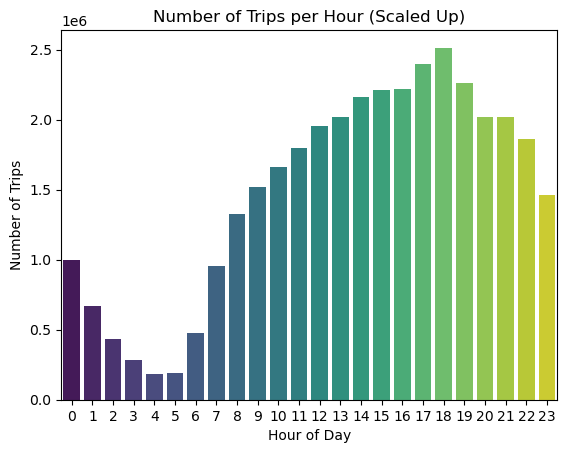

In [324]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.02
hourly_trips['scaled_trip_count'] = hourly_trips['trip_count'] / sample_fraction
hourly_trips.sort_values('scaled_trip_count',ascending=False).head(5)
sns.barplot(x='hour', y='scaled_trip_count', data=hourly_trips, palette='viridis')
plt.title('Number of Trips per Hour (Scaled Up)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

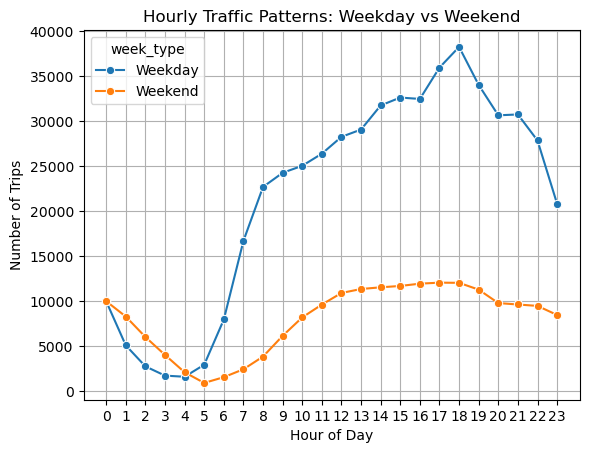

In [192]:
# Compare traffic trends for the week days and weekends
df_speed['week_type'] = df_speed['day_of_week'].apply(lambda x: 'Weekend' if x in ['Sunday', 'Saturday'] else 'Weekday')
hourly_week_traffic = df_speed.groupby(['hour', 'week_type']).size().reset_index(name='trip_count')
# plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_week_traffic, x='hour', y='trip_count', hue='week_type', marker='o')
plt.title('Hourly Traffic Patterns: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

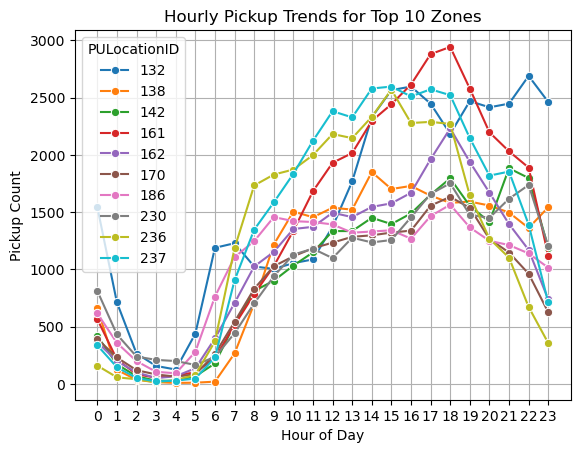

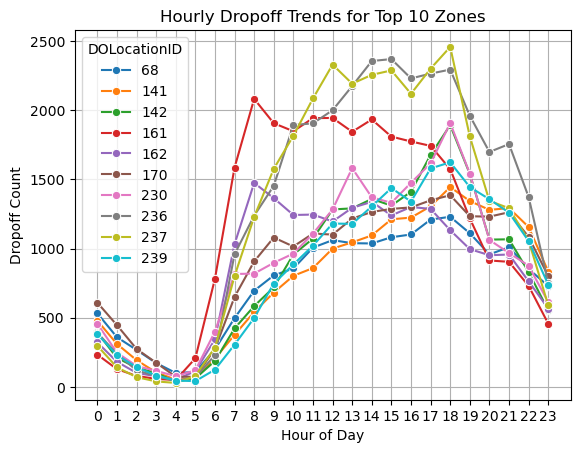

In [198]:
# Find top 10 pickup and dropoff zones
# Hourly pickups
pickup_counts = df_speed.groupby(['PULocationID', 'hour']).size().reset_index(name='pickup_count')
# Hourly dropoffs
dropoff_counts = df_speed.groupby(['DOLocationID', 'hour']).size().reset_index(name='dropoff_count')
# Total pickups and dropoffs by zone
top_pickup_zones = df_speed['PULocationID'].value_counts().head(10).index
top_dropoff_zones = df_speed['DOLocationID'].value_counts().head(10).index
# Filter for top 10 pickup zones
top_pickup_trends = pickup_counts[pickup_counts['PULocationID'].isin(top_pickup_zones)]
# Filter for top 10 dropoff zones
top_dropoff_trends = dropoff_counts[dropoff_counts['DOLocationID'].isin(top_dropoff_zones)]
# Plot hourly pickups
sns.lineplot(data=top_pickup_trends, x='hour', y='pickup_count', hue='PULocationID', palette='tab10',marker='o')
plt.title('Hourly Pickup Trends for Top 10 Zones')
plt.xlabel('Hour of Day')
plt.ylabel('Pickup Count')
plt.legend(title='PULocationID')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()
# Plot hourly dropoffs
sns.lineplot(data=top_dropoff_trends, x='hour', y='dropoff_count', hue='DOLocationID', palette='tab10',marker='o')
plt.title('Hourly Dropoff Trends for Top 10 Zones')
plt.xlabel('Hour of Day')
plt.ylabel('Dropoff Count')
plt.legend(title='DOLocationID')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [200]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
pickup_counts = df_speed['PULocationID'].value_counts().rename('pickup_count')
dropoff_counts = df_speed['DOLocationID'].value_counts().rename('dropoff_count')
zone_ratio = pd.concat([pickup_counts, dropoff_counts], axis=1).fillna(0)
zone_ratio['pickup_dropoff_ratio'] = zone_ratio['pickup_count'] / zone_ratio['dropoff_count'].replace(0, np.nan)
zone_ratio = zone_ratio.replace([np.inf, -np.inf], np.nan).dropna(subset=['pickup_dropoff_ratio'])
# Top 10 zones with highest pickup-to-dropoff ratio
top_10 = zone_ratio.sort_values('pickup_dropoff_ratio', ascending=False).head(10)

# Bottom 10 zones with lowest pickup-to-dropoff ratio
bottom_10 = zone_ratio.sort_values('pickup_dropoff_ratio', ascending=True).head(10)

print("Top 10 Pickup/Dropoff Ratio Zones:")
print(top_10)

print("\nBottom 10 Pickup/Dropoff Ratio Zones:")
print(bottom_10)

Top 10 Pickup/Dropoff Ratio Zones:
     pickup_count  dropoff_count  pickup_dropoff_ratio
70         3240.0            362              8.950276
132       37581.0           7629              4.926072
138       25148.0           8438              2.980327
186       24742.0          15921              1.554048
43        12178.0           8723              1.396079
114        9245.0           6808              1.357961
249       15971.0          11840              1.348902
162       25786.0          20571              1.253512
161       33612.0          27753              1.211112
100       11801.0           9911              1.190697

Bottom 10 Pickup/Dropoff Ratio Zones:
     pickup_count  dropoff_count  pickup_dropoff_ratio
187           0.0              1                   0.0
99            0.0              1                   0.0
206           0.0             14                   0.0
251           0.0             12                   0.0
221           0.0             11              

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [202]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
night_df = df_speed[(df_speed['hour'] >= 23) | (df_speed['hour'] <= 5)]
# Count top pickup zones
top_night_pickups = night_df['PULocationID'].value_counts().head(10).rename_axis('PULocationID').reset_index(name='pickup_count')

# Count top dropoff zones
top_night_dropoffs = night_df['DOLocationID'].value_counts().head(10).rename_axis('PULocationID').reset_index(name='dropoff_count')

top_night_pickups = top_night_pickups.merge(zones, on='PULocationID')
top_night_dropoffs = top_night_dropoffs.merge(zones, on='PULocationID')
print("Top 10 Night Pickup Zones (11PM to 5AM):")
print(top_night_pickups[['zone', 'pickup_count']])

print("\nTop 10 Night Dropoff Zones (11PM to 5AM):")
print(top_night_dropoffs[['zone', 'dropoff_count']])


Top 10 Night Pickup Zones (11PM to 5AM):
                           zone  pickup_count
0                  East Village          6028
1                   JFK Airport          5709
2                  West Village          4933
3                  Clinton East          4039
4               Lower East Side          3830
5       Greenwich Village South          3317
6     Times Sq/Theatre District          3269
7  Penn Station/Madison Sq West          2674
8                 Midtown South          2444
9             LaGuardia Airport          2405

Top 10 Night Dropoff Zones (11PM to 5AM):
                            zone  dropoff_count
0                   East Village           3216
1                   Clinton East           2808
2                    Murray Hill           2449
3                       Gramercy           2325
4                   East Chelsea           2266
5                Lenox Hill West           2031
6                 Yorkville West           1943
7                   West V

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [206]:
# Filter for night hours (11 PM to 5 AM)
night_df = df_speed[df_speed['hour'].isin([23, 0, 1, 2, 3, 4, 5])]
# Total revenue and nighttime revenue
total_revenue = df_speed['total_amount'].sum()
night_revenue = night_df['total_amount'].sum()

# Revenue share for night
night_revenue_share = night_revenue / total_revenue

print(f"Nighttime revenue share (11PM–5AM): {night_revenue_share:.2%}")


Nighttime revenue share (11PM–5AM): 12.07%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

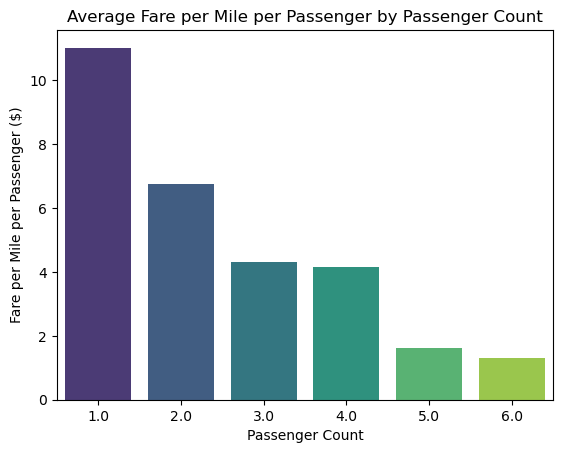

In [212]:
# Analyse the fare per mile per passenger for different passenger counts
valid_df = df_speed[(df_speed['trip_distance'] > 0) & (df_speed['passenger_count'] > 0)]

# Calculate fare per mile per passenger
valid_df['fare_per_mile_per_passenger'] = valid_df['fare_amount'] / (valid_df['trip_distance'] * valid_df['passenger_count'])

# Group by passenger count and calculate average fare per mile per passenger
fare_analysis = valid_df.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index()

sns.barplot(data=fare_analysis, x='passenger_count', y='fare_per_mile_per_passenger', palette='viridis')
plt.title('Average Fare per Mile per Passenger by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare per Mile per Passenger ($)')
plt.show()


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

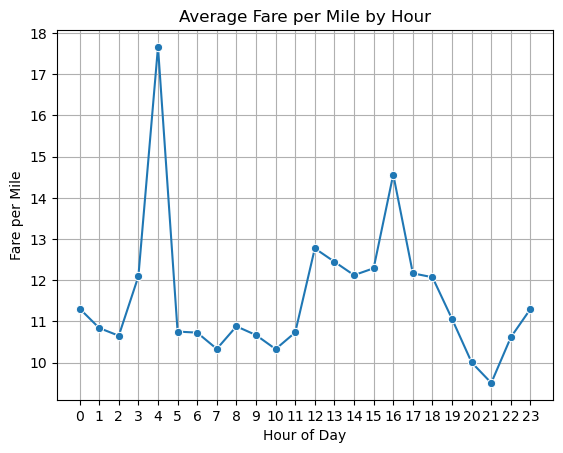

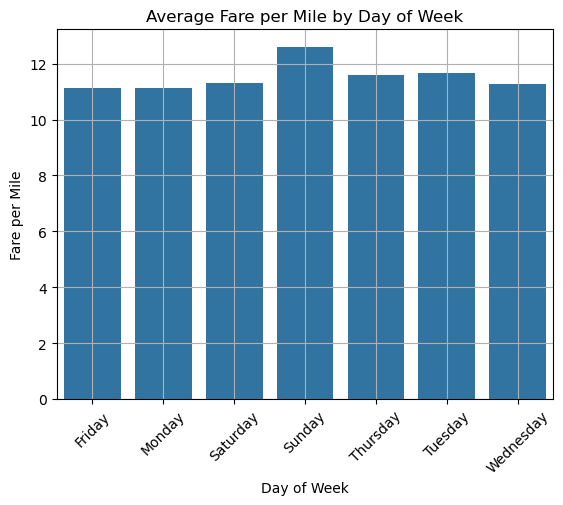

In [220]:
# Compare the average fare per mile for different days and for different times of the day
valid_df['fare_per_mile'] = valid_df['fare_amount'] / valid_df['trip_distance']

# Step 4: Group by hour
avg_fare_per_mile_hour = valid_df.groupby('hour')['fare_per_mile'].mean().reset_index()

# Step 5: Group by day of week
avg_fare_per_mile_day = valid_df.groupby('day_of_week')['fare_per_mile'].mean().reset_index()

sns.lineplot(data=avg_fare_per_mile_hour, x='hour', y='fare_per_mile',marker='o')
plt.title('Average Fare per Mile by Hour')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 24))
plt.ylabel('Fare per Mile')
plt.grid(True)
plt.show()

# Daily trend
sns.barplot(data=avg_fare_per_mile_day, x='day_of_week', y='fare_per_mile')
plt.title('Average Fare per Mile by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fare per Mile')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

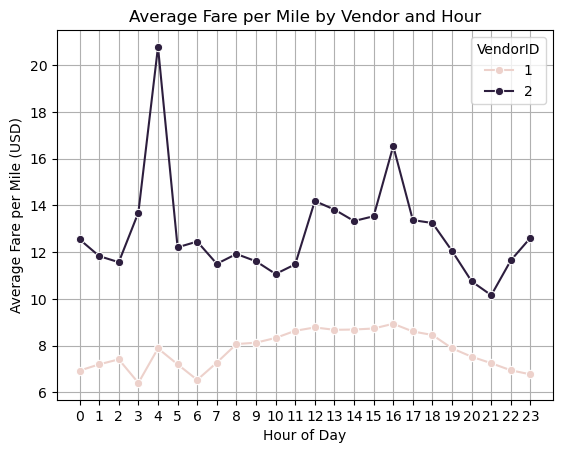

In [234]:
# Compare fare per mile for different vendors
vendor_hourly_fare = valid_df.groupby(['VendorID', 'hour'])['fare_per_mile'].mean().reset_index()

sns.lineplot(data=vendor_hourly_fare, x='hour', y='fare_per_mile', hue='VendorID', marker='o')
plt.title('Average Fare per Mile by Vendor and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare per Mile (USD)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(title='VendorID')
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [236]:
# Defining distance tiers
# Create distance tiers
def distance_tier(dist):
    if dist <= 2:
        return '0-2 miles'
    elif dist <= 5:
        return '2-5 miles'
    else:
        return '5+ miles'

valid_df['distance_tier'] = valid_df['trip_distance'].apply(distance_tier)
vendor_fare_tiers = valid_df.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().reset_index()

# Pivot for easier comparison
fare_tier_pivot = vendor_fare_tiers.pivot(index='distance_tier', columns='VendorID', values='fare_per_mile')
fare_tier_pivot

VendorID              1          2
distance_tier                     
0-2 miles      9.906580  18.383849
2-5 miles      6.371268   6.546553
5+ miles       4.415384   4.503464

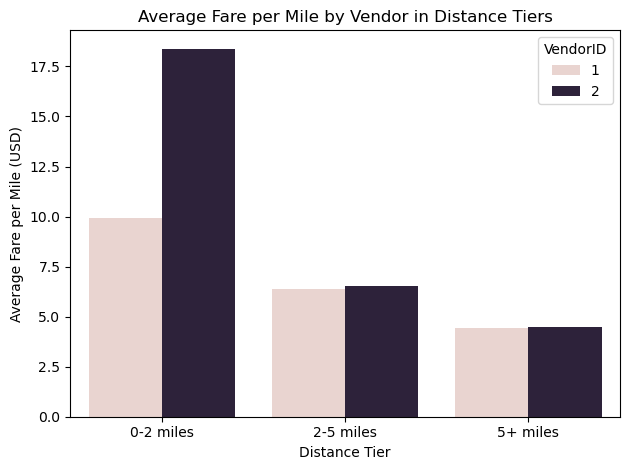

In [240]:
sns.barplot(data=vendor_fare_tiers, x='distance_tier', y='fare_per_mile', hue='VendorID')
plt.title('Average Fare per Mile by Vendor in Distance Tiers')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare per Mile (USD)')
plt.tight_layout()
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [242]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
# Filter valid entries to avoid division by zero
valid_df = valid_df[(valid_df['fare_amount'] > 0) & (valid_df['tip_amount'] >= 0)].copy()

# Calculate tip percentage
valid_df['tip_percent'] = (valid_df['tip_amount'] / valid_df['fare_amount']) * 100

In [244]:
# Create distance bins
bins = [0, 2, 5, 10, 20, valid_df['trip_distance'].max()]
labels = ['0-2 mi', '2-5 mi', '5-10 mi', '10-20 mi', '20+ mi']
valid_df['distance_bin'] = pd.cut(valid_df['trip_distance'], bins=bins, labels=labels, include_lowest=True)

# Group by distance bin
tip_by_distance = valid_df.groupby('distance_bin')['tip_percent'].mean().reset_index()
tip_by_passenger = valid_df.groupby('passenger_count')['tip_percent'].mean().reset_index()
valid_df['hour'] = valid_df['tpep_pickup_datetime'].dt.hour
tip_by_hour = valid_df.groupby('hour')['tip_percent'].mean().reset_index()

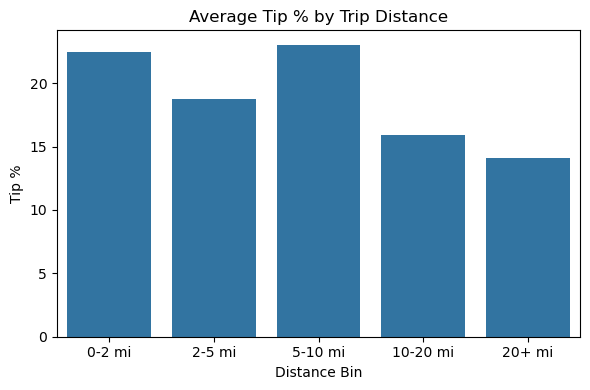

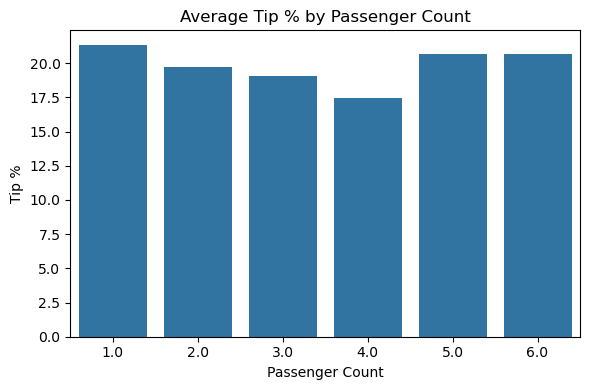

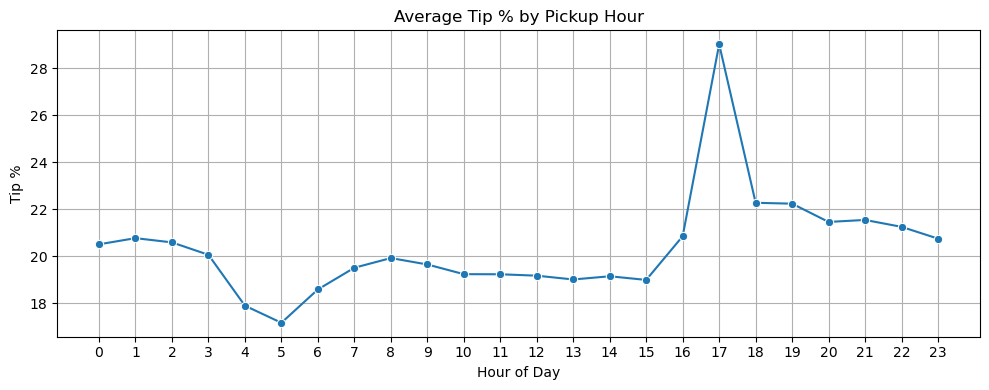

In [246]:
# Tip vs Distance
plt.figure(figsize=(6,4))
sns.barplot(data=tip_by_distance, x='distance_bin', y='tip_percent')
plt.title("Average Tip % by Trip Distance")
plt.ylabel("Tip %")
plt.xlabel("Distance Bin")
plt.tight_layout()
plt.show()

# Tip vs Passenger Count
plt.figure(figsize=(6,4))
sns.barplot(data=tip_by_passenger, x='passenger_count', y='tip_percent')
plt.title("Average Tip % by Passenger Count")
plt.ylabel("Tip %")
plt.xlabel("Passenger Count")
plt.tight_layout()
plt.show()

# Tip vs Hour
plt.figure(figsize=(10,4))
sns.lineplot(data=tip_by_hour, x='hour', y='tip_percent', marker='o')
plt.title("Average Tip % by Pickup Hour")
plt.ylabel("Tip %")
plt.xlabel("Hour of Day")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

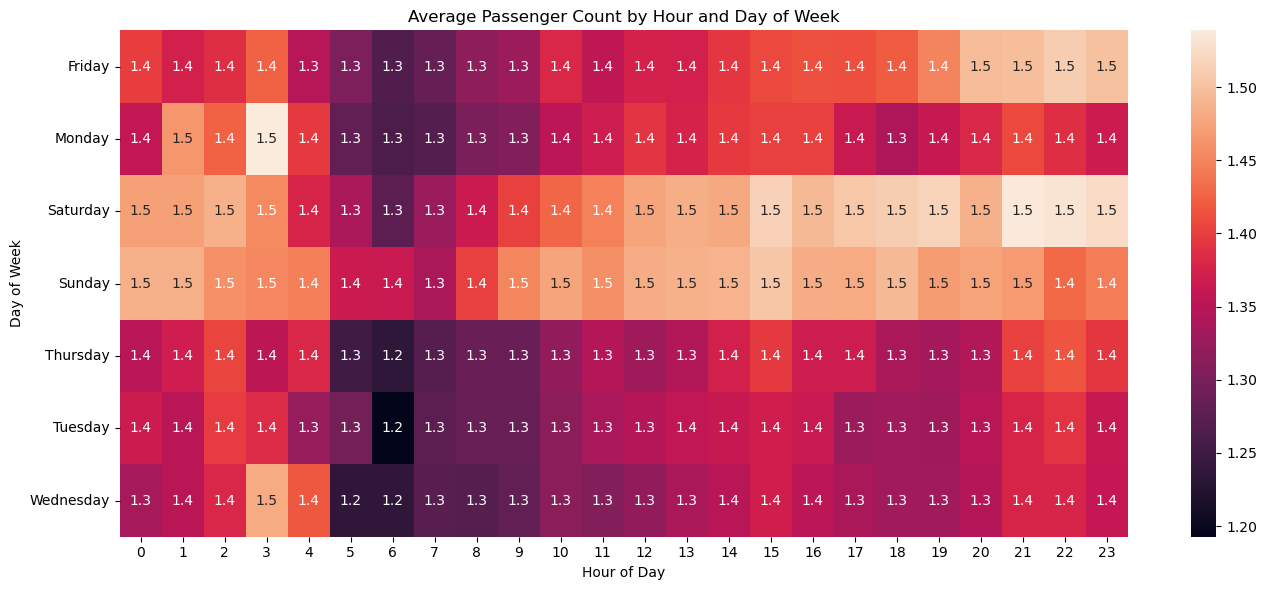

In [250]:
# See how passenger count varies across hours and days
passenger_by_time = valid_df.groupby(['day_of_week', 'hour'])['passenger_count'].mean().unstack()

plt.figure(figsize=(14, 6))
sns.heatmap(passenger_by_time, annot=True)
plt.title('Average Passenger Count by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()



**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

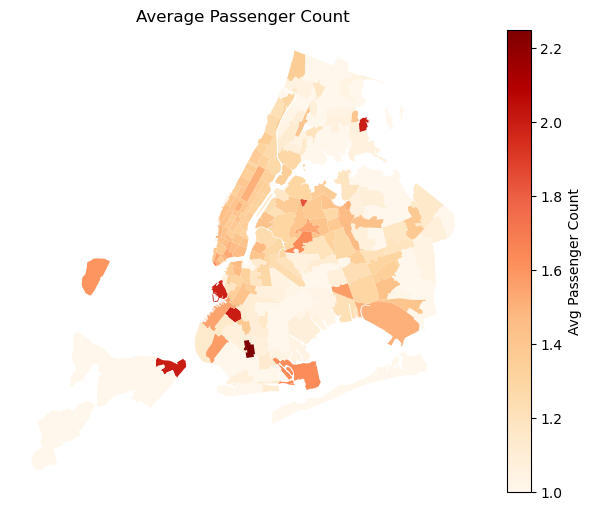

In [254]:
avg_passenger_by_zone = valid_df.groupby('PULocationID')['passenger_count'].mean().reset_index()
zone_passenger = zones.merge(avg_passenger_by_zone, left_on='PULocationID', right_on='PULocationID')

fig, ax = plt.subplots(1, 1, figsize=(8,6))
zone_passenger.plot(
    column='passenger_count',
    ax=ax,
    legend=True,
    cmap='OrRd',
    legend_kwds={'label': "Avg Passenger Count", 'orientation': "vertical"}
)
plt.title("Average Passenger Count")
plt.axis('off')
plt.show()


In [260]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.



Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

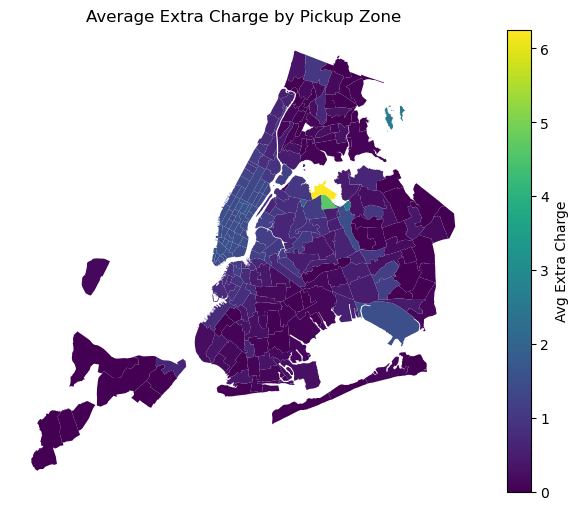

In [264]:
# How often is each surcharge applied?
zone_extra = valid_df.groupby('PULocationID')['extra'].mean().reset_index()
# Merge with zones GeoDataFrame
zones_extra_merged = zones.merge(zone_extra, left_on='PULocationID', right_on='PULocationID', how='left')

fig, ax = plt.subplots(1, 1, figsize=(8,6))
zones_extra_merged.plot(
    column='extra',
    ax=ax,
    legend=True,
    legend_kwds={'label': "Avg Extra Charge", 'orientation': "vertical"}
)
plt.title("Average Extra Charge by Pickup Zone")
plt.axis('off')
plt.show()



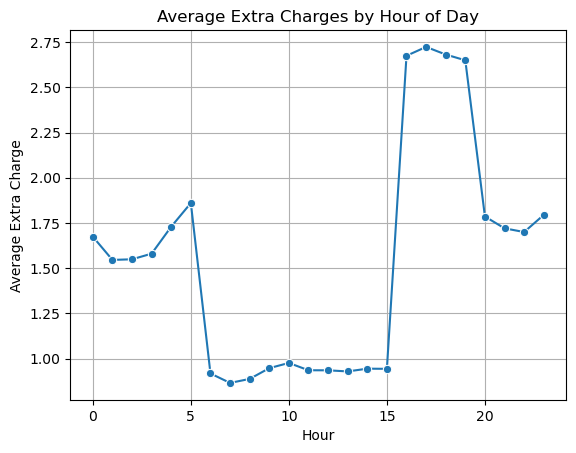

In [266]:
hourly_extra = valid_df.groupby('hour')['extra'].mean().reset_index()

sns.lineplot(x='hour', y='extra', data=hourly_extra, marker='o')
plt.title('Average Extra Charges by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Extra Charge')
plt.grid(True)
plt.show()

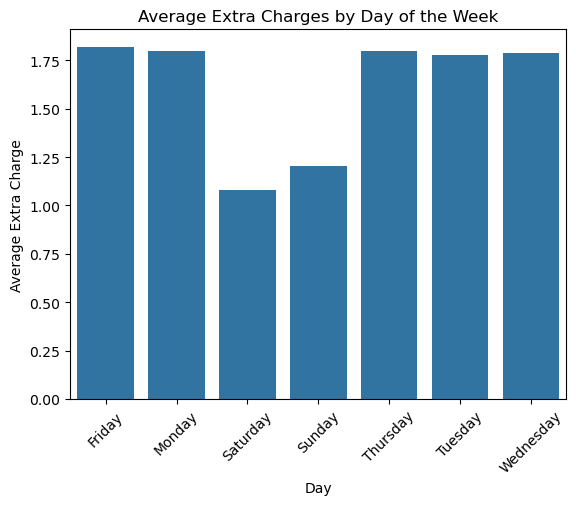

In [268]:
weekday_extra = valid_df.groupby('day_of_week')['extra'].mean().reset_index()

sns.barplot(x='day_of_week', y='extra', data=weekday_extra)
plt.title('Average Extra Charges by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Average Extra Charge')
plt.xticks(rotation=45)
plt.show()


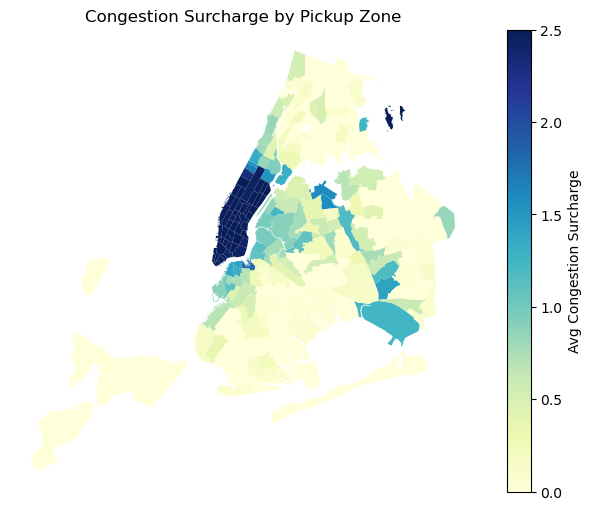

In [270]:
zone_congestion = valid_df.groupby('PULocationID')['congestion_surcharge'].mean().reset_index()
zones_congestion = zones.merge(zone_congestion, left_on='PULocationID', right_on='PULocationID', how='left')

# Plot as choropleth
fig, ax = plt.subplots(1, 1, figsize=(8,6))
zones_congestion.plot(
    column='congestion_surcharge',
    ax=ax,
    legend=True,
    cmap='YlGnBu',
    legend_kwds={'label': "Avg Congestion Surcharge", 'orientation': "vertical"}
)
plt.title("Congestion Surcharge by Pickup Zone")
plt.axis('off')
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

Trip durations and slow routes were observed during rush hours, especially in high-density zones.
Avoid dispatching cabs through high-traffic zones during rush hours.
Implement dynamic rerouting systems based on hourly trip durations and bottlenecks.
Use historical traffic speed data to plan routes with better efficiency and lower idle time.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

Zones like Midtown East, Upper East Side, JFK Airport, LaGuardia, Times Square, and East Village recorded high pickups and drop-offs across all timeframes.
Nighttime zones with consistently high traffic include areas around Meatpacking District, East Village, and SoHo.
Increase cab availability in high pickup zones during peak hours.
Position more cabs in airport zones during early morning and late evening hours when flight arrivals and departures spike.
Maintain a minimum cab presence in outer boroughs during off-peak times to reduce long wait times.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

Introduce a tiered fare model: slightly higher fare per mile for short distances (to maximize on quick trips) and incentivized fares for long trips during low-demand hours.
Use surge pricing in zones with high demand and low supply, especially during weekends and special events.
Vendor 1 offered more consistent pricing across distances.
Fare per mile was highest for short trips (under 2 miles), especially for Vendor 2. For longer trips (over 5 miles), the fare per mile drops significantly.
Efficient routing and dynamic cab positioning can cut costs and reduce idle time.
A flexible, data-driven pricing strategy that adjusts with demand patterns will maximize both customer satisfaction and revenue.
Leveraging historical and real-time data is the key to balancing supply with demand in NYC’s fast-moving taxi landscape.